# Pulsar Classification Analysis

# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# Models 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from xgboost import XGBClassifier

# Data Processing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import make_scorer
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA


# Model Processing
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# K Best columns
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif

# Functions

In [5]:
def check_for_dupes_nans(df:pd.DataFrame):
    """
    Checks for dupes and nulls
    """
    amount_of_dupes = df.duplicated().sum()
    print(f"Null Count: {df.isna().sum()}")
    print(f"Dupe Count: {amount_of_dupes}")

def check_class_imbalance(df:pd.DataFrame, target:pd.Series, col:str):
  counter = Counter(target)
  for k,v in counter.items():
    per = v/len(target) * 100
    print("Class=%s, Count=%d, Percentage=%.3f%%" % (k,v, per))
  
  ax = df[col].value_counts().sort_index().plot(
  kind="bar", 
  title="Count of Reviews by Target", 
  figsize=(10,5)
  )
  ax.set_xlabel(col)
  plt.show()

def check_for_dupes_nans(df:pd.DataFrame):
    """
    Checks for dupes and nulls
    """
    amount_of_dupes = df.duplicated().sum()
    print(f"Null Count: {df.isna().sum()}")
    print(f"Dupe Count: {amount_of_dupes}")

# EDA Analysis

In [4]:
df = pd.read_csv("/Users/maukanmir/Downloads/Pulsar_cleaned.csv")
df

,Mean_Integrated,EK,Skewness,Mean_DMSNR_Curve,SD_DMSNR_Curve,EK_DMSNR_Curve,Skewness_DMSNR_Curve,Class
0,140.562500,1.502969,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,0.788423,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,0.323558,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,0.958983,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,1.232198,1.123492,1.178930,11.468720,14.269573,252.567306,0
...,...,...,...,...,...,...,...,...
14982,96.000000,0.537495,0.281344,1.871237,15.833746,9.634927,104.821623,0
14983,136.429688,1.349991,-0.738123,1.296823,12.166062,15.450260,285.931022,0
14984,122.554688,0.316006,0.323061,16.409699,44.626893,2.945244,8.297092,0
14985,119.335938,0.213253,-0.743025,21.430602,58.872000,2.499517,4.595173,0


# Check for Dupes and Nulls

In [6]:
check_for_dupes_nans(df)

Null Count: Mean_Integrated         0
EK                      0
Skewness                0
Mean_DMSNR_Curve        0
SD_DMSNR_Curve          0
EK_DMSNR_Curve          0
Skewness_DMSNR_Curve    0
Class                   0
dtype: int64
Dupe Count: 0


# Check for class Imbalance

Class=0, Count=14679, Percentage=97.945%
Class=1, Count=308, Percentage=2.055%


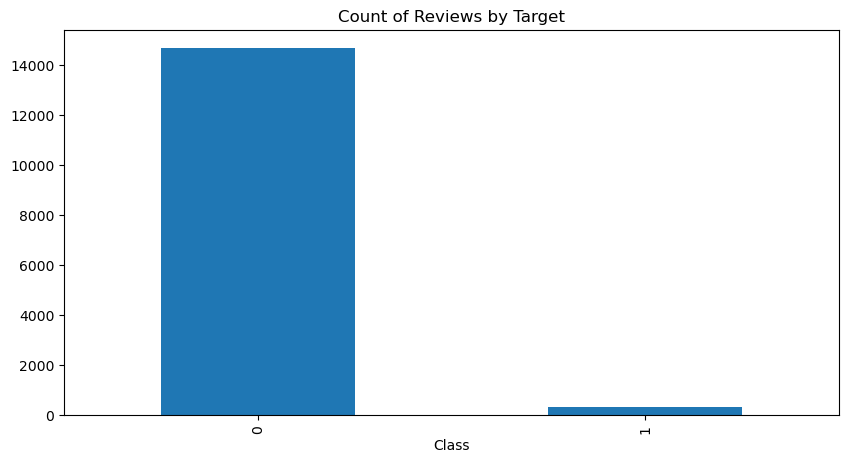

In [8]:
check_class_imbalance(df, df['Class'], "Class")

# We have a severe class imbalance which will require over sampling methods in order to properly evaluate our model.